In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import bisect
from scipy.special import erf
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many
prefix = "cnv_long"
num_runs = 24

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import pickle
from os.path import exists

if exists("{}_times_shaheen.p".format(prefix)):
    with open("{}_times_shaheen.p".format(prefix), "rb") as f:
        times_shaheen = pickle.load(f)
else:
    times_shaheen = {}

if exists("{}_times_mira.p".format(prefix)):
    with open("{}_times_mira.p".format(prefix), "rb") as f:
        times_mira = pickle.load(f)
else:
    times_mira = {}
table_s = CachedSlict(times_shaheen)
table_m = CachedSlict(times_mira)

In [3]:
config = Foo()
orders = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32]
#elms = [4, 8, 12, 16, 20, 24, 28, 32]
elms = [1, 2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 128]
config.names = []
for order in orders:
    for elm in elms:
        #f (order, elm) in table_s[:,:,'time'].keys() and (order, elm) in table_m[:,:,'time'].keys():
        #    continue
        if order * elm >= 32 and order * elm <= 512:
            config.names.append("{:}_o{:d}_e{:d}/{:}_o{:d}_e{:d}".format(prefix, order, elm, prefix, order, elm))       

In [4]:
def read_outfile(f):
    ans = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    num_proc = 1
    for line in f.readlines():
        if "Number of processors:" in line:
            num_proc = int(line.split()[3])
        if "total time" in line:
            ans["time"] = float(line.split()[2])*num_proc
        if "Total    " in line:
            ans["gflops"] = float(line.split()[1])
            ans["gibs"] = float(line.split()[3])
    if ans["time"] < 0.0001:
        print("output file didn't complete: {}".format(f.name))
    ans["gflops"]  = ans["gflops"]  * ans["time"] 
    ans["gibs"]  = ans["gibs"]  * ans["time"]
    return ans

In [5]:
config.arch_end = "maxhutch#alpha-admin/~/pub/ConvergeRTI_Shaheen/"
from globussh import ls
from os.path import join
for name in config.names:            
    sol = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    try:
        out_files = ls(join(config.arch_end, name + "*.output"))
    except:
        print("{:} is skipped".format(name))
        continue
    paths = [join(*(name.split("/")[0:-1] + [of,])) for of in out_files]
    if len(paths) != num_runs:
        print("{:} is incomplete".format(name))
        continue
    with glopen_many(paths, mode='r', endpoint=config.arch_end) as fs:
        for f in fs:
            part = read_outfile(f)
            for k in part:
                sol[k] += part[k]
    with glopen(
                "{:s}.json".format(name), mode='r',
                endpoint = config.arch_end,
                ) as f:
        p = json.load(f)
    for k in sol:
        times_shaheen[p['order'], p['shape_mesh'][0], k] = sol[k]

cnv_long_o4_e8/cnv_long_o4_e8 is skipped
cnv_long_o4_e12/cnv_long_o4_e12 is skipped
cnv_long_o4_e16/cnv_long_o4_e16 is skipped
cnv_long_o4_e24/cnv_long_o4_e24 is skipped
cnv_long_o4_e32/cnv_long_o4_e32 is skipped
cnv_long_o4_e48/cnv_long_o4_e48 is skipped
cnv_long_o4_e64/cnv_long_o4_e64 is skipped
cnv_long_o4_e96/cnv_long_o4_e96 is skipped
cnv_long_o4_e128/cnv_long_o4_e128 is skipped
cnv_long_o6_e8/cnv_long_o6_e8 is skipped
cnv_long_o6_e12/cnv_long_o6_e12 is skipped
cnv_long_o6_e16/cnv_long_o6_e16 is skipped
cnv_long_o6_e24/cnv_long_o6_e24 is skipped
cnv_long_o6_e32/cnv_long_o6_e32 is skipped
cnv_long_o6_e48/cnv_long_o6_e48 is skipped
cnv_long_o6_e64/cnv_long_o6_e64 is skipped
cnv_long_o8_e4/cnv_long_o8_e4 is skipped
cnv_long_o8_e8/cnv_long_o8_e8 is skipped
cnv_long_o8_e12/cnv_long_o8_e12 is skipped
cnv_long_o8_e16/cnv_long_o8_e16 is skipped
cnv_long_o8_e24/cnv_long_o8_e24 is skipped
cnv_long_o8_e48/cnv_long_o8_e48 is skipped
cnv_long_o8_e64/cnv_long_o8_e64 is skipped
cnv_long_o10_e4/c

In [6]:
def make_plots(times, bw, name):
    table = CachedSlict(times)
    fig, ax = plt.subplots(1)
    ax.loglog([4,32],[10**4,(8**4)*10**4], 'k-')
    for order in orders:
        ax.loglog(table[order,:,'time'].keys(), table[order,:,'time'].values(), 'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('Total core hours')
    plt.legend()
    
    fig, ax = plt.subplots(1)
    for order in orders:
        ax.loglog(table[order,:,'gflops'].keys(), table[order,:,'gflops'].values(), 'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('GFLOP')
    plt.legend()

    fig, ax = plt.subplots(1)
    for order in orders:
        ax.plot(table[order,:,'gflops'].keys(), 
                np.array(table[order,:,'gflops'].values())/np.array(table[order,:,'time'].values()), 
                'x--', label="Order={}".format(order))
    plt.xlabel('Number of elements on x-axis')
    plt.ylabel('GFLOPs / core')
    plt.legend()

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.axhline(bw, color='black')
    for order in orders:
        ax.semilogx((np.array(table[order,:,'gibs'].keys())*order)**3*4, 
                np.array(table[order,:,'gibs'].values())/np.array(table[order,:,'time'].values()), 
                'x--', label="Order={}".format(order))
    plt.xlabel('Total points')
    plt.ylabel('Memory bandwidth per core (GiB/s)')
    plt.ylim(0,int(bw)+1)
    #plt.legend(loc=8, ncol=3)
    plt.legend(ncol=3)
    plt.savefig('{}-bw.pdf'.format(name))

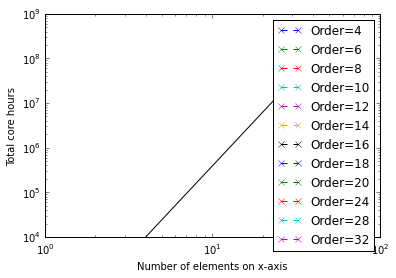

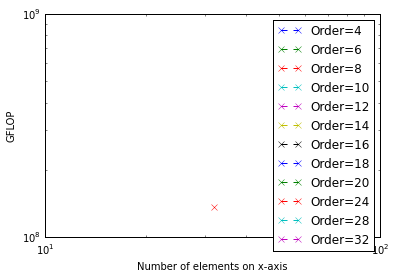

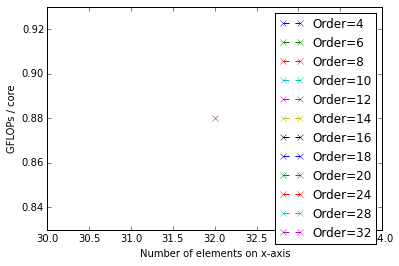

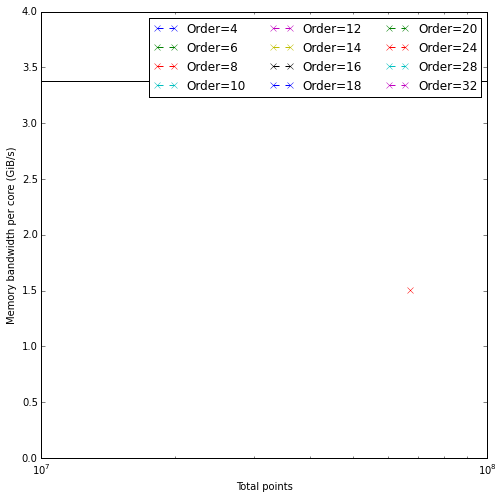

In [7]:
make_plots(times_shaheen, 108./32., 'shaheen')

In [8]:
#config.arch_end = "maxhutch#alpha-admin/~/pub/ConvergeRTI/"
#config.arch_end = "alcf#dtn_mira/projects/HighAspectRTI/experiments/ConvergeRTI/"
config.arch_end = "alcf#dtn_mira/projects/alpha-nek/experiments/ConvergeRTI/"
from globussh import ls
from os.path import join
for name in config.names:    
    sol = {"time": 0.0, "gflops": 0.0, "gibs": 0.0}
    parts = name.rpartition("/")
    #out_files = ls(join(config.arch_end, parts[0], "stdout", parts[2] + "*.output"))
    try:
        out_files = ls(join(config.arch_end, name + "*.output"))
    except:
        print("{:} is skipped".format(name))
        continue
    paths = [join(*(name.split("/")[0:-1] + [of,])) for of in out_files]
    if len(paths) != num_runs:
        print("{:} is incomplete".format(name))
        continue
    with glopen_many(paths, mode='r', endpoint=config.arch_end) as fs:
        for f in fs:
            part = read_outfile(f)
            for k in part:
                sol[k] += part[k]
    with glopen(
                "{:s}.json".format(name), mode='r',
                endpoint = config.arch_end,
                ) as f:
        p = json.load(f)
    for k in sol:
        times_mira[p['order'], p['shape_mesh'][0], k] = sol[k]
    if p['order'] <= 24:
        times_mira[p['order'], p['shape_mesh'][0], 'time'] /= 4
    else:
        times_mira[p['order'], p['shape_mesh'][0], 'time'] /= 2

cnv_long_o4_e12/cnv_long_o4_e12 is incomplete
cnv_long_o4_e24/cnv_long_o4_e24 is skipped
cnv_long_o4_e32/cnv_long_o4_e32 is skipped
cnv_long_o4_e48/cnv_long_o4_e48 is skipped
cnv_long_o4_e64/cnv_long_o4_e64 is incomplete
cnv_long_o4_e96/cnv_long_o4_e96 is skipped
cnv_long_o4_e128/cnv_long_o4_e128 is skipped
cnv_long_o6_e8/cnv_long_o6_e8 is skipped
cnv_long_o6_e12/cnv_long_o6_e12 is skipped
cnv_long_o6_e16/cnv_long_o6_e16 is skipped
cnv_long_o6_e24/cnv_long_o6_e24 is skipped
cnv_long_o6_e32/cnv_long_o6_e32 is skipped
cnv_long_o6_e48/cnv_long_o6_e48 is skipped
cnv_long_o6_e64/cnv_long_o6_e64 is skipped
cnv_long_o8_e12/cnv_long_o8_e12 is skipped
cnv_long_o8_e24/cnv_long_o8_e24 is skipped
cnv_long_o8_e32/cnv_long_o8_e32 is incomplete
cnv_long_o8_e48/cnv_long_o8_e48 is skipped
cnv_long_o8_e64/cnv_long_o8_e64 is skipped
cnv_long_o10_e4/cnv_long_o10_e4 is skipped
cnv_long_o10_e8/cnv_long_o10_e8 is skipped
cnv_long_o10_e12/cnv_long_o10_e12 is skipped
cnv_long_o10_e16/cnv_long_o10_e16 is skippe

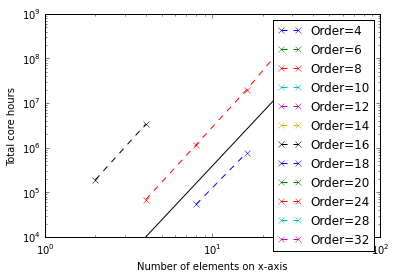

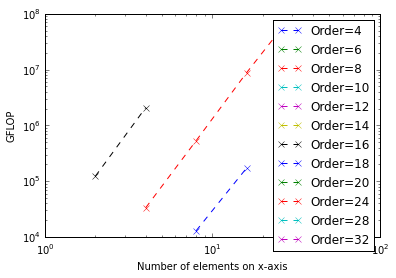

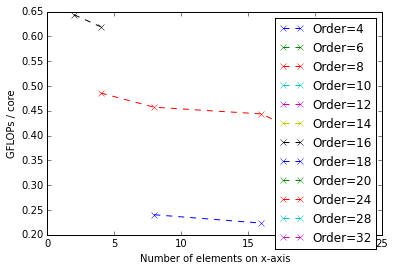

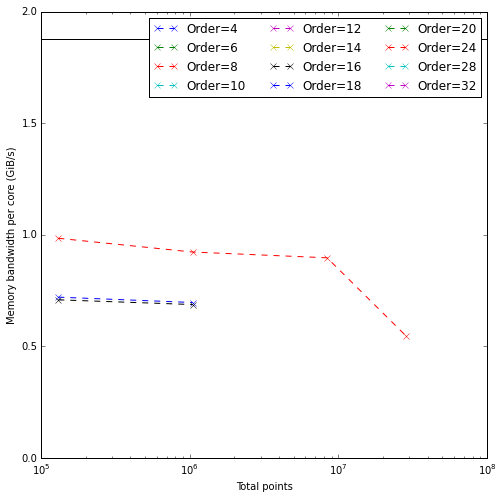

In [9]:
make_plots(times_mira, 30./16., 'mira')

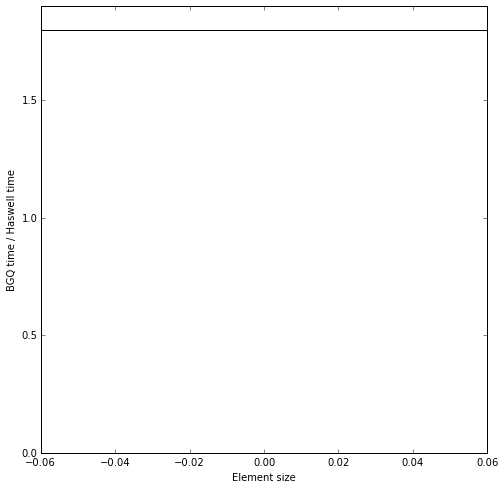

In [10]:
table_mira = CachedSlict(times_mira)
table_shaheen = CachedSlict(times_shaheen)
plt.figure(figsize=(8,8))
plt.axhline(1.8, color='black')
plt.plot([k[0]for k in table_mira[:,:,'time'] if k in table_shaheen[:,:,'time']],
         [table_mira[k[0],k[1],'time'] / table_shaheen[k[0],k[1],'time'] for k in table_mira[:,:,'time'] if k in table_shaheen[:,:,'time']], 'x')
plt.ylim(0)
plt.xlabel("Element size")
plt.ylabel("BGQ time / Haswell time")
plt.savefig("mira_vs_haswell.pdf")

In [11]:
import pickle
with open("{}_times_shaheen.p".format(prefix), "wb") as f:
    pickle.dump(times_shaheen, f)
with open("{}_times_mira.p".format(prefix), "wb") as f:
    pickle.dump(times_mira, f)    